In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from supervenn import supervenn
import os
import mygene


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def unify_gene_ids_and_symbols(df):

    ## Make a copy to use in function
    dff = df.copy()
    
    ## Take out . from ensembl ids
    dff["ensembl_id"] = dff["ensembl_id"].str.split(".", expand=True)[0]

    # Standardize all NaN-like values to pd.NA
    dff = dff.replace({np.nan: pd.NA, None: pd.NA})

    ## Set gene ids that are not ensembl IDs to NA
    dff['ensembl_id'] = dff['ensembl_id'].apply(lambda x: x if pd.isna(x) or str(x).startswith('ENS') else pd.NA)

    ## Get all the unique gene_id and gene_symbols
    df_ids = dff["ensembl_id"].copy().drop_duplicates(inplace=False).dropna(inplace=False).to_list()

    ## Query by gene_ids and gene_symbols
    mg = mygene.MyGeneInfo()
    results_id_query = mg.querymany(df_ids, scopes='symbol,alias,name,ensembl.gene,ensembl.transcript', fields='symbol,ensembl.gene', species='human', as_dataframe=True, df_index=False, returnall=False)

    ## Delete duplicates, only keep highest value
    results_id_query = results_id_query.sort_values(by=['query', '_score'], ascending=[True, False]).drop_duplicates(subset='query', keep='first')
    
    # Ensure that the column 'ensembl' is of string type, which allows the use of string methods
    results_id_query["ensembl"] = results_id_query["ensembl"].astype(str)
    
    # Split the strings and handle NaNs by chaining the .str methods
    results_id_query["first_ensembl"] = results_id_query["ensembl"].str.split(":", expand=True)[1].str.split("'", expand=True)[1]

    
    # Standardize all NaN-like values to pd.NA
    results_id_query = results_id_query.replace({np.nan: pd.NA, None: pd.NA, "nan": pd.NA})
    
    # Fill NA values in 'ensembl.gene' column with values from 'first_ensembl' column
    results_id_query['ensembl.gene'] = results_id_query['ensembl.gene'].copy().fillna(results_id_query['first_ensembl'], inplace=False)

    ## Only keep relevant columns
    results_id_query = results_id_query[["query", "ensembl.gene", "symbol"]].copy()

    ## Rename columns
    results_id_query.columns = ["ensembl_id", "from_id_ensembl_id", "from_id_official_gene_symbol"]

    results_id_query.drop_duplicates(inplace=True)

    
    ## Merge with original dataframe
    dff = dff.merge(results_id_query, how="left", on="ensembl_id")

    ## Combine results from both approaches (symbol and id)
    dff['official_symbol'] = dff['from_id_official_gene_symbol'].copy()

    ## Drop intermediate columns
    dff.drop(columns=["from_id_ensembl_id", "from_id_official_gene_symbol"], inplace=True)

    ## Drop anything that is missing both ensembl_id and official_symbol
    dff.dropna(subset=["ensembl_id", "official_symbol"], how="all", inplace=True)
    
    ## Drop Duplicates
    dff.drop_duplicates(inplace=True)
    
    ## Make ensembl id and official symbol the first two columns 
    dff = dff[dff.columns[-2:].tolist() + dff.columns[:-2].tolist()].copy()

    return dff

In [3]:
import os
import pandas as pd

def get_dataframes_with_string(path: str, search_string: str) -> list:
    """
    Reads all CSV files in the specified directory that contain the given search string 
    in their filenames and returns a list of pandas DataFrames.
    
    Parameters:
    path (str): The directory path where the CSV files are located.
    search_string (str): The string to search for in the filenames.
    
    Returns:
    list: A list of pandas DataFrames, each corresponding to a CSV file whose name contains 
          the search string.
          
    Example:
    --------
    >>> dataframes = get_dataframes_with_string('/path/to/csv/files', 'example')
    >>> for df in dataframes:
    >>>     print(df)
    """
    dataframes = []
    
    # Iterate over all files in the given directory
    for filename in os.listdir(path):
        # Check if the file is a CSV file and contains the search string in its name
        if filename.endswith(".csv") and search_string in filename:
            # Create the full file path
            file_path = os.path.join(path, filename)
            # Read the CSV file into a dataframe
            df = pd.read_csv(file_path)
            # Append the dataframe to the list
            dataframes.append(df)
    
    return dataframes

In [4]:
def analyze_gene_data(dataframes: list) -> tuple:
    """
    Analyzes a list of dataframes to extract gene names that are upregulated 
    and downregulated in Alzheimer's Disease (AD) and the study names.
    
    Parameters:
    dataframes (list): A list of pandas DataFrames, each containing columns 
                       'gene_name' (str), 'is_upregulated_in_AD' (bool), and 'study' (str).
    
    Returns:
    tuple: A tuple containing four elements:
           1. A list of sets, each set containing gene names that are upregulated in AD for each dataframe.
           2. A list of sets, each set containing gene names that are downregulated in AD for each dataframe.
           3. A list of strings with the study name for each dataframe.
           4. A pandas DataFrame with a row for each gene name and a column for each study, 
              indicating if the gene is upregulated, downregulated, or missing in each study.
    
    Example:
    --------
    >>> dfs = [df1, df2, df3]
    >>> upregulated_genes, downregulated_genes, study_names, gene_summary_df = analyze_gene_data(dfs)
    >>> print(upregulated_genes)
    >>> print(downregulated_genes)
    >>> print(study_names)
    >>> print(gene_summary_df)
    """
    # Initialize lists to store the upregulated and downregulated genes for each dataframe
    upregulated_genes = []
    downregulated_genes = []
    study_names = []
    
    # Initialize a set to keep track of all unique gene names across all dataframes
    all_genes = set()

    # Iterate over each dataframe in the input list
    for df in dataframes:
        # Identify the set of upregulated genes in the current dataframe
        upregulated_set = set(df[df['is_upregulated_in_AD']]['gene_name'])
        # Identify the set of downregulated genes in the current dataframe
        downregulated_set = set(df[~df['is_upregulated_in_AD']]['gene_name'])
        # Extract the study name from the 'study' column of the current dataframe
        study_name = df['study'].iloc[0] if not df['study'].empty else None
        
        # Append the sets of upregulated and downregulated genes to their respective lists
        upregulated_genes.append(upregulated_set)
        downregulated_genes.append(downregulated_set)
        # Append the study name to the study names list
        study_names.append(study_name)
        # Update the set of all unique genes with the genes from the current dataframe
        all_genes.update(upregulated_set)
        all_genes.update(downregulated_set)
    
    # Create a DataFrame to summarize the gene regulation status across all studies
    gene_summary_df = pd.DataFrame(index=sorted(all_genes))

    # Iterate over each dataframe again to fill the summary DataFrame
    for idx, df in enumerate(dataframes):
        # Get the study name for the current dataframe
        study_name = study_names[idx]
        # Initialize the column for the current study with 'missing' status
        gene_summary_df[study_name] = "missing"
        # Get the sets of upregulated and downregulated genes for the current dataframe
        upregulated_set = upregulated_genes[idx]
        downregulated_set = downregulated_genes[idx]
        
        # Mark the upregulated genes in the current study as 'upregulated'
        gene_summary_df.loc[list(upregulated_set), study_name] = "upregulated"
        # Mark the downregulated genes in the current study as 'downregulated'
        gene_summary_df.loc[list(downregulated_set), study_name] = "downregulated"

    # Add columns for the number of upregulated and downregulated studies
    gene_summary_df['upregulated_count'] = (gene_summary_df == 'upregulated').sum(axis=1)
    gene_summary_df['downregulated_count'] = (gene_summary_df == 'downregulated').sum(axis=1)
    
    # Reset the index to turn the index into a column
    gene_summary_df.reset_index(inplace=True)
    # Rename the index column to 'gene_name'
    gene_summary_df.rename(columns={'index': 'gene_name'}, inplace=True)
    

    # Return the lists of upregulated and downregulated genes, study names, and the summary DataFrame
    return upregulated_genes, downregulated_genes, study_names, gene_summary_df

In [5]:
## Open meta-analysis data
temporal_meta = pd.read_csv("../../data/processed_data/temporal_lobe/temporal_lobe_meta-analysis_processed_results.tsv", sep="\t")
frontal_meta = pd.read_csv("../../data/processed_data/frontal_lobe/frontal_lobe_meta-analysis_processed_results.tsv", sep="\t")

In [6]:
temporal_meta_up = temporal_meta.loc[temporal_meta['regulation'] == "Upregulated in AD"].copy()
temporal_meta_down = temporal_meta.loc[temporal_meta['regulation'] == "Downregulated in AD"].copy()
frontal_meta_up = frontal_meta.loc[frontal_meta['regulation'] == "Upregulated in AD"].copy()
frontal_meta_down = frontal_meta.loc[frontal_meta['regulation'] == "Downregulated in AD"].copy()

In [7]:
## Load data for each brain region
temporal_up = pd.read_csv("../../data/processed_data/other_studies_DEGs/temporal_up_in_AD.csv")
temporal_down = pd.read_csv("../../data/processed_data/other_studies_DEGs/temporal_down_in_AD.csv")
frontal_up = pd.read_csv("../../data/processed_data/other_studies_DEGs/frontal_up_in_AD.csv")
frontal_down = pd.read_csv("../../data/processed_data/other_studies_DEGs/frontal_down_in_AD.csv")

In [8]:
## Make Marques-Coelho into 1 study
temporal_up.loc[temporal_up["study"].str.startswith("Marques"), "study"] = "Marques-Coelho_et_al"
temporal_down.loc[temporal_down["study"].str.startswith("Marques"), "study"] = "Marques-Coelho_et_al"
frontal_up.loc[frontal_up["study"].str.startswith("Marques"), "study"] = "Marques-Coelho_et_al"
frontal_down.loc[frontal_down["study"].str.startswith("Marques"), "study"] = "Marques-Coelho_et_al"

In [9]:
## Drop duplicates
temporal_up.drop_duplicates(inplace=True)
temporal_down.drop_duplicates(inplace=True)
frontal_up.drop_duplicates(inplace=True)
frontal_down.drop_duplicates(inplace=True)

In [10]:
## Unify gene symbols
temporal_up = unify_gene_ids_and_symbols(temporal_up)
temporal_down = unify_gene_ids_and_symbols(temporal_down)
frontal_up = unify_gene_ids_and_symbols(frontal_up)
frontal_down = unify_gene_ids_and_symbols(frontal_down)

146 input query terms found no hit:	['ENSG00000231865', 'ENSG00000268759', 'ENSG00000197846', 'ENSG00000176034', 'ENSG00000264868', 'ENS
1 input query terms found dup hits:	[('ENSG00000230373', 2)]
120 input query terms found no hit:	['ENSG00000235261', 'ENSG00000272091', 'ENSG00000269871', 'ENSG00000270172', 'ENSG00000232224', 'ENS
1 input query terms found no hit:	['ENSG00000184258']
13 input query terms found no hit:	['ENSG00000270188', 'ENSG00000256618', 'ENSG00000270672', 'ENSG00000255823', 'ENSG00000269028', 'ENS


In [11]:
## Create unique hits dataframe
temporal_up_unique = temporal_meta_up.loc[~temporal_meta_up["gene_id"].isin(temporal_up['ensembl_id'])]
temporal_down_unique = temporal_meta_down.loc[~temporal_meta_down["gene_id"].isin(temporal_down['ensembl_id'])]
frontal_up_unique = frontal_meta_up.loc[~frontal_meta_up["gene_id"].isin(frontal_up['ensembl_id'])]
frontal_down_unique = frontal_meta_down.loc[~frontal_meta_down["gene_id"].isin(frontal_down['ensembl_id'])]

In [12]:
## Look at overlap between other studies and our DEGs
temporal_up = temporal_up.loc[temporal_up["ensembl_id"].isin(temporal_meta_up['gene_id'])]
temporal_down = temporal_down.loc[temporal_down["ensembl_id"].isin(temporal_meta_down['gene_id'])]
frontal_up = frontal_up.loc[frontal_up["ensembl_id"].isin(frontal_meta_up['gene_id'])]
frontal_down = frontal_down.loc[frontal_down["ensembl_id"].isin(frontal_meta_down['gene_id'])]


In [13]:
# Count occurrences of each value in the 'Category' column and store it in a DataFrame
temporal_up_counts = temporal_up.groupby('ensembl_id').agg(
    Count=('ensembl_id', 'size'),
    Studies=('study', lambda x: ', '.join(x))
).reset_index()

temporal_down_counts = temporal_down.groupby('ensembl_id').agg(
    Count=('ensembl_id', 'size'),
    Studies=('study', lambda x: ', '.join(x))
).reset_index()

frontal_up_counts = frontal_up.groupby('ensembl_id').agg(
    Count=('ensembl_id', 'size'),
    Studies=('study', lambda x: ', '.join(x))
).reset_index()

frontal_down_counts = frontal_down.groupby('ensembl_id').agg(
    Count=('ensembl_id', 'size'),
    Studies=('study', lambda x: ', '.join(x))
).reset_index()



In [14]:
## Clean up add dataframe
temporal_up_unique_add = temporal_up_unique[["gene_id", "regulation"]].copy()
temporal_down_unique_add = temporal_down_unique[["gene_id", "regulation"]].copy()
frontal_up_unique_add = frontal_up_unique[["gene_id", "regulation"]].copy()
frontal_down_unique_add = frontal_down_unique[["gene_id", "regulation"]].copy()

temporal_up_unique_add["Counts"] = 0
temporal_down_unique_add["Counts"] = 0
frontal_up_unique_add["Counts"] = 0
frontal_down_unique_add["Counts"] = 0

In [15]:
## Drop regulation column
temporal_up_unique_add.drop(columns="regulation", inplace=True)
temporal_down_unique_add.drop(columns="regulation", inplace=True)
frontal_up_unique_add.drop(columns="regulation", inplace=True)
frontal_down_unique_add.drop(columns="regulation", inplace=True)

In [16]:
## Define studies Column
temporal_up_unique_add["Studies"] = np.NaN
temporal_down_unique_add["Studies"] = np.NaN
frontal_up_unique_add["Studies"] = np.NaN
frontal_down_unique_add["Studies"] = np.NaN

In [17]:
## Change the column names
temporal_up_unique_add.columns = ["ensembl_id", "Count", "Studies"]
temporal_down_unique_add.columns = ["ensembl_id", "Count", "Studies"]
frontal_up_unique_add.columns = ["ensembl_id", "Count", "Studies"]
frontal_down_unique_add.columns = ["ensembl_id", "Count", "Studies"]

In [18]:
## Concatenate
temporal_up_counts = pd.concat([temporal_up_counts, temporal_up_unique_add])
temporal_down_counts = pd.concat([temporal_down_counts, temporal_down_unique_add])
frontal_up_counts = pd.concat([frontal_up_counts, frontal_up_unique_add])
frontal_down_counts = pd.concat([frontal_down_counts, frontal_down_unique_add])

In [19]:
## Add regulation
temporal_up_counts["regulation"] = "Upregulated in AD"
temporal_down_counts["regulation"] = "Downregulated in AD"
frontal_up_counts["regulation"] = "Upregulated in AD"
frontal_down_counts["regulation"] = "Downregulated in AD"

In [20]:
## Concatenate
temporal_counts = pd.concat([temporal_up_counts, temporal_down_counts])
frontal_counts = pd.concat([frontal_up_counts, frontal_down_counts])

In [21]:
## Setup figure size
from matplotlib import rcParams
mm = (1/25.4)

# figure size in inches
rcParams['figure.figsize'] = (170*mm, 52*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

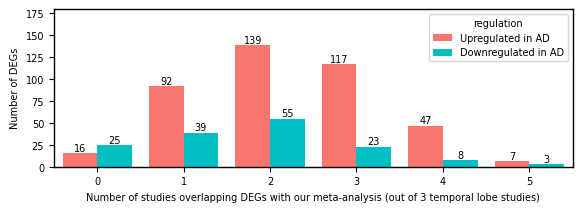

In [22]:
## Make median CPM > 1 gene body number of exons plot and save both as pdf.

ax = sns.countplot(x=temporal_counts["Count"], hue=temporal_counts["regulation"], palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Number of studies overlapping DEGs with our meta-analysis (out of 3 temporal lobe studies)")
plt.ylabel("Number of DEGs")
plt.ylim(0, 180)

plt.savefig('../../figures/main/temporal_lobe_overlap.pdf',
            dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../figures/main/temporal_lobe_overlap.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

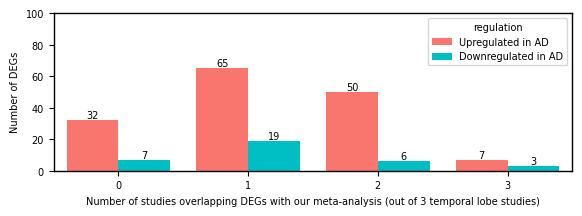

In [23]:
## Make median CPM > 1 gene body number of exons plot and save both as pdf.

ax = sns.countplot(x=frontal_counts["Count"], hue=frontal_counts["regulation"], palette=[ggplot2_colors[0], ggplot2_colors[4]], saturation=1)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Number of studies overlapping DEGs with our meta-analysis (out of 3 temporal lobe studies)")
plt.ylabel("Number of DEGs")
plt.ylim(0, 100)

plt.savefig('../../figures/main/temporal_lobe_overlap.pdf',
            dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../figures/main/temporal_lobe_overlap.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

In [24]:
## Adjust column names
temporal_meta.columns = ['chr', 'ensembl_id', 'gene_symbol', 'P-value', 'Zscore', 'Direction',
       'regulation', 'heterogeneity_I_squared', 'heterogeneity_Chi_squared',
       'heterogeneity_degrees_of_freedom_squared', 'heterogeneity_P-value']
frontal_meta.columns = ['chr', 'ensembl_id', 'gene_symbol', 'P-value', 'Zscore', 'Direction',
       'regulation', 'heterogeneity_I_squared', 'heterogeneity_Chi_squared',
       'heterogeneity_degrees_of_freedom_squared', 'heterogeneity_P-value']

In [25]:
## Add gene symbol
temporal_counts = temporal_counts.merge(temporal_meta[["ensembl_id", "gene_symbol"]], on="ensembl_id", how="inner")
frontal_counts = frontal_counts.merge(frontal_meta[["ensembl_id", "gene_symbol"]], on="ensembl_id", how="inner")

In [26]:
## Make gene symbol the first column
temporal_counts = temporal_counts[["ensembl_id", "gene_symbol", "Count", "Studies", "regulation"]]
frontal_counts = frontal_counts[["ensembl_id", "gene_symbol", "Count", "Studies", "regulation"]]

## Change column names
temporal_counts.columns = ["gene_id", "gene_symbol", "count", "studies", "regulation"]
frontal_counts.columns = ["gene_id", "gene_symbol", "count", "studies", "regulation"]

In [33]:
## Sort table
temporal_counts.sort_values(by=["regulation", "count"], ascending=[False, False], inplace=True)
frontal_counts.sort_values(by=["regulation", "count"], ascending=[False, False], inplace=True)

In [34]:
## Write output
temporal_counts.to_csv("../../data/processed_data/other_studies_DEGs/temporal_counts_all_overlap.tsv", sep="\t", index=False)
frontal_counts.to_csv("../../data/processed_data/other_studies_DEGs/frontal_counts_all_overlap.tsv", sep="\t", index=False)